In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import gamma
import numpy as np
from numpy import prod
import matplotlib.pyplot as plt
import pprint
from tqdm.notebook import tqdm
%matplotlib inline

In [3]:
plt.rcParams['xtick.color'] = "white"
plt.rcParams['ytick.color'] = "white"
plt.rcParams['text.color'] = "black"
plt.rcParams['axes.labelcolor'] = "white"

In [4]:
def load_data():
    d = open("survivor_data.txt","r").readlines()
    data = pd.DataFrame()
    for feature in d:
        f = feature.split(" ")
        data[f[0].strip(": ")] = list(map(lambda x: float(x),f[1:-1]))
    return data

In [5]:
#data = (data-data.mean())/data.std()

In [47]:
 class Gibbs(object):
    def __init__(self, data, TRAILS, burn_in, y, x):
        self.TRAILS = TRAILS
        self.SAMPLES = len(data)
        self.data = data
        self.x = x
        self.y = y
        self.burn_in = int(TRAILS * burn_in)
        self.trace = self.get_trace()
        
    def get_trace(self):
        return {
            "trail": list(i for i in range(self.TRAILS)),
            "samples":list(self.SAMPLES for _ in range(self.TRAILS)),

            "mu0": list(None for i in range(self.TRAILS)),
            "tau0": list(None for i in range(self.TRAILS)), 
            "proposal_b0": list(None for i in range(self.TRAILS)), 

            "mu1": list(None for i in range(self.TRAILS)), 
            "tau1": list(None for i in range(self.TRAILS)),
            "proposal_b1": list(None for i in range(self.TRAILS)),

            "SSE": list(None for i in range(self.TRAILS)), # Sum squared error
            "predicted_linear": list(np.zeros((self.SAMPLES,)) for i in range(self.TRAILS)), # a matrix of predicted values for each y_i will be generated at each trail
            "predicted_posterior": list(np.zeros((self.SAMPLES,)) for i in range(self.TRAILS)),

            "alpha": list(None for i in range(self.TRAILS)),
            "beta": list(None for i in range(self.TRAILS)),
            "proposal_tau": list(None for i in range(self.TRAILS)),

            "likelihood": list(None for i in range(self.TRAILS)), # likelihood of model given the data
            "log_likelihood" : list(None for i in range(self.TRAILS)),
            "neg_double_log_likelihood" : list(None for i in range(self.TRAILS)),
        }
        
    def set_priors(self):
        self.trace["mu0"][0] = 0
        self.trace["tau0"][0] = 0.0001
        self.trace["mu1"][0] = 0
        self.trace["tau1"][0] = 0.0001
        self.trace["alpha"][0] = 0.01
        self.trace["beta"][0] = 0.01

    def prime_MCMC(self):
        """Set starting point""" 
        self.trace["proposal_b0"][0] = 6
        self.trace["proposal_b1"][0] = 0.3
        self.trace["proposal_tau"][0] = None 

    def compute_SSE(self, trail):
        for i, observation in self.data.iterrows():
            intercept = self.trace["proposal_b0"][trail]
            slope = self.trace["proposal_b1"][trail] 
            x = observation[self.x]
            self.trace["predicted_linear"][trail][i] = intercept + (slope * x)
        diff = self.data[self.y].values - np.array(self.trace["predicted_linear"][trail])
        self.trace["SSE"][trail] = sum([err**2 for err in diff])
        
        
    def update_tau_parameters(self, trail):
        """Update the proposal distribution of tau, conditioned on the current values of b0 and b1"""
        # The prior of alpha and beta is always chosen as the first term in the conjugate solution update.
        # and we have always the same sample size
        n = self.trace["samples"][0]
        alpha_prior = self.trace["alpha"][0]
        self.trace["alpha"][trail] = alpha_prior + (n / 2)

        # We use the previous rounds Sum squared error to update beta. i.e the intercept and slope from the previous
        # round is used to update beta.
        beta_prior = self.trace["beta"][0]
        self.trace["beta"][trail] = beta_prior + (self.trace["SSE"][trail-1] / 2)
        
    def update_tau_proposal(self, trail):
        # numpy uses scale = 1/rate
        rate = self.trace["beta"][trail]
        scale = 1/rate
        self.trace["proposal_tau"][trail] = np.random.gamma(shape=self.trace["alpha"][trail], scale=scale)
    
    def update_b0_parameters(self, trail):
        tau0_prior = trace["tau0"][0]
        mu0_prior = trace["mu0"][0]
        n = trace["samples"][0]

        trace["mu0"][trail] = ((tau0_prior * mu0_prior) + \
                            trace["proposal_tau"][trail] * \
                            sum([
                                obs[self.y] - (trace["proposal_b1"][trail-1] * obs[self.x])
                            for _, obs in data.iterrows()])) / (tau0_prior + n * trace["proposal_tau"][trail])

        trace["tau0"][trail] = tau0_prior + (n * trace["proposal_tau"][trail])
    
    def update_b0_parameters(self, trail):
        tau0_prior = self.trace["tau0"][0]
        mu0_prior = self.trace["mu0"][0]
        n = self.trace["samples"][0]

        self. trace["mu0"][trail] = ((tau0_prior * mu0_prior) + \
                            self.trace["proposal_tau"][trail] * \
                            sum([
                                obs[self.y] - (self.trace["proposal_b1"][trail-1] * obs[self.x])
                            for _, obs in self.data.iterrows()])) / (tau0_prior + n * self.trace["proposal_tau"][trail])

        self.trace["tau0"][trail] = tau0_prior + (n * self.trace["proposal_tau"][trail])
    
    def update_b0_proposal(self, trail):
        mu = self.trace["mu0"][trail]
        std = np.sqrt(1/self.trace["tau0"][trail])
        self.trace["proposal_b0"][trail] = np.random.normal(mu, std)
        
    def update_b1_parameters(self, trail):
        tau1_prior = self.trace["tau1"][0]
        mu1_prior = self.trace["mu1"][0]
        n = self.trace["samples"][0]
        squared_data = sum([obs[self.x]**2 for _, obs in self.data.iterrows()])

        self.trace["mu1"][trail] = ((tau1_prior * mu1_prior) + \
                            self.trace["proposal_tau"][trail] * \
                            sum([
                                 obs[self.x] * (obs[self.y] - self.trace["proposal_b0"][trail])
                            for _, obs in self.data.iterrows()])) / (tau1_prior + (self.trace["proposal_tau"][trail] * squared_data))

        self.trace["tau1"][trail] = (tau1_prior + (self.trace["proposal_tau"][trail] * squared_data))
        
    def update_b1_proposal(self, trail):
        mu = self.trace["mu1"][trail]
        std = np.sqrt(1/self.trace["tau1"][trail])
        self.trace["proposal_b1"][trail] = np.random.normal(mu, std)
    
    def predict_posterior(self, trail):
        mu = self.trace["predicted_linear"][trail]
        std = 1/np.sqrt(self.trace["proposal_tau"][trail])
        self.trace["predicted_posterior"][trail] = np.random.normal(mu,std) 
        
    def _normal(self, tau, y, pred):
        return np.sqrt(tau)/np.sqrt(2*np.pi) * np.exp((-tau/2)*((y-pred)**2))

    def compute_likelihoods(self, trail):
        intercept = self.trace["proposal_b0"][trail]
        slope = self.trace["proposal_b1"][trail]
        tau = self.trace["proposal_tau"][trail]
        like = [ self._normal(tau, obs[self.y], intercept+slope*obs[self.x]) for _, obs in self.data.iterrows() ]
        self.trace["likelihood"][trail] = prod(like)
        self.trace["log_likelihood"][trail] = sum(map(np.log,like))
        self.trace["neg_double_log_likelihood"][trail] = sum(map(lambda l: -2*np.log(l),like))

    def sample(self):
        self.compute_SSE(0) # first we need the Sum squared error to update Tau in the first round
        for trail in tqdm(range(1, self.TRAILS)): # Now comes the rest of the trails..
            #update tau (error term)
            self.update_tau_parameters(trail)
            self.update_tau_proposal(trail)
            #update intercept
            self.update_b0_parameters(trail)
            self.update_b0_proposal(trail)
            #update slope
            self.update_b1_parameters(trail)
            self.update_b1_proposal(trail)
            # Compute sum squared error
            self.compute_SSE(trail)
            # Compute model likelihoods
            self.compute_likelihoods(trail)
            # Predict using posterior
            self.predict_posterior(trail)
            
        self.get_trace_dataframe() # removes burn in trails
        
    def summarize(self):
        self.summary = self.trace_df[["proposal_b0",
                           "proposal_b1",
                           "proposal_tau",
                           "neg_double_log_likelihood"]].agg(["min","max","mean","median","std"]).T
        self.alpha_posterior = self.trace_df["alpha"].iloc[-1]
        self.beta_posterior = self.alpha_posterior / self.trace_df["proposal_tau"].mean()
        display(self.summary)
        print("Posterior alpha: {} \nPosterior beta: {}".format(self.alpha_posterior, self.beta_posterior))
     
    def compute_DIC(self):
        """
        Deviance Information Criterion: https://en.wikipedia.org/wiki/Deviance_information_criterion
        DIC = mean(negative_log_likelihood_x2 + P_D), Where P_D is the effective number of parameters.
        where P_D = mean(D) - D_hat, where D_hat = -2*log_likelihood when we plug in the mean of all 
        parameters across all MCMC trails.
        Smaller DIC is better!
        """
        intercept = self.trace_df["proposal_b0"].mean()
        slope = self.trace_df["proposal_b1"].mean()
        tau = self.trace_df["proposal_tau"].mean()
        like = [ self._normal(tau, obs[self.y], intercept+slope*obs[self.x]) for _, obs in self.data.iterrows() ]
        D_hat = sum(map(lambda l: -2*np.log(l), like))
        D_mean = self.trace_df["neg_double_log_likelihood"].mean()
        P_D = D_mean - D_hat
        self.dic = D_mean + P_D
        print("DIC: {}".format(self.dic))
    
    def diagnose_correlated_chains(self):
        """TODO! """
        self.pass
    
    def plot_sse(self):
        print("Burn in trails are included")
        plt.plot(self.trace["SSE"], label="Sum squared error (incl burn in trails)")
        plt.legend()
        plt.show()
        
    def plot_likelihood(self):
        print("Burn in trails are included")
        plt.plot(self.trace["likelihood"], label="Likelihood")
        plt.legend()
        plt.show()
        plt.plot(self.trace["log_likelihood"], color="g", label = "log Likelihood")
        plt.legend()
        plt.show()
        plt.plot(self.trace["neg_double_log_likelihood"], color="r", label = "Negative double log Likelihood")
        plt.legend()
        plt.show()
    
    def plot_posterior(self):
        print("Burn in trails are removed")
        plt.hist(self.trace_df["proposal_b0"],bins=20, label="proposal_b0")
        plt.legend()
        plt.show()
        plt.hist(self.trace_df["proposal_b1"], color="r", bins=20, label="proposal_b1")
        plt.legend()
        plt.show()
        plt.hist(self.trace_df["proposal_tau"], color="g", bins=20, label="proposal_tau")
        plt.legend()
        plt.show()
        plt.hist([1/x for x in self.trace_df["proposal_tau"]], color="g", bins=20, alpha=0.3, label="proposal_sigma = 1/sqrt(tau)")
        plt.legend()
        plt.show()
        
    def plot_posterior_predictive_dist(self):
        # plot data
        print("Burn in trails are removed")
        self.data.plot.scatter(x="years_in_school", y="success", color="k", marker=",", label="Data", s=40)
        #plot credible 95% interval of predictions
        predictions_linear = np.array(list(x for x in self.trace_df["predicted_linear"].values))[:,:]
        lower_credible_interval_linear = np.percentile(predictions_linear, 2.5, axis=0)
        upper_credible_interval_linear = np.percentile(predictions_linear, 97.5, axis=0)
        plt.scatter(self.data["years_in_school"], lower_credible_interval_linear, color="b", alpha=0.3, marker="x", label="95% credible interval linear prediction")
        plt.scatter(self.data["years_in_school"], upper_credible_interval_linear, color="b", alpha=0.3, marker="x")
        # plot posterior predictive distroibution
        predictions_posterior = np.array(list(x for x in self.trace_df["predicted_posterior"].values))[:,:]
        lower_credible_interval_posterior = np.percentile(predictions_posterior, 2.5, axis=0)
        upper_credible_interval_posterior = np.percentile(predictions_posterior, 97.5, axis=0)
        plt.scatter(self.data["years_in_school"], lower_credible_interval_posterior, color="r", alpha=0.3, marker="x", label="95% credible interval posterior predictive dist")
        plt.scatter(self.data["years_in_school"], upper_credible_interval_posterior, color="r", alpha=0.3, marker="x")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def get_trace_dataframe(self):
        df = pd.DataFrame().from_dict(self.trace)
        self.trace_df = df.iloc[self.burn_in:, :]

In [48]:
data =  load_data()
gibbs_sampler = Gibbs(data,
                      y = "success",
                      x = "years_in_school",
                      TRAILS=1000, 
                      burn_in = 0.25)
gibbs_sampler.set_priors()
gibbs_sampler.prime_MCMC()
gibbs_sampler.sample()

,min,max,mean,median,std
proposal_b0,-13.793805,29.523410,7.994950,8.050462,7.647879
proposal_b1,0.623808,3.475062,2.004194,2.007329,0.487946
proposal_tau,0.002887,0.045927,0.016491,0.015458,0.006272
neg_double_log_likelihood,102.123398,118.201997,105.293114,104.540628,2.590846


Posterior alpha: 7.51 
Posterior beta: 455.4007875148235
DIC: 108.36544160431787
Burn in trails are removed


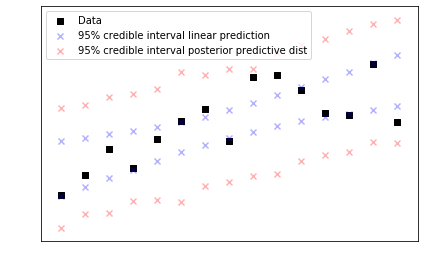

Burn in trails are included


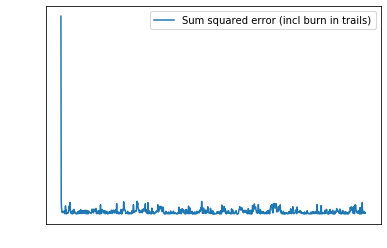

Burn in trails are included


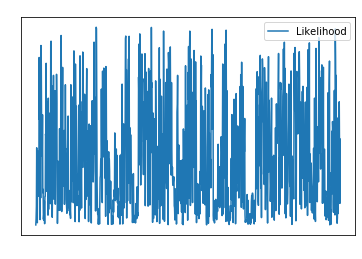

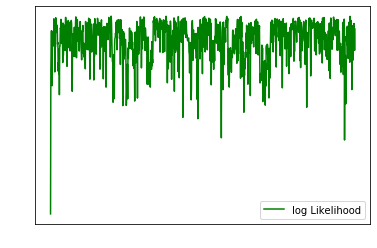

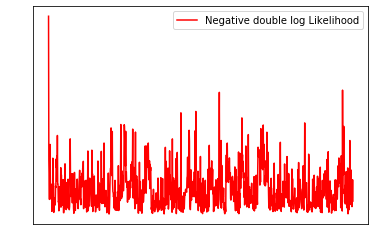

Burn in trails are removed


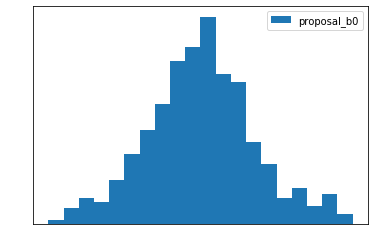

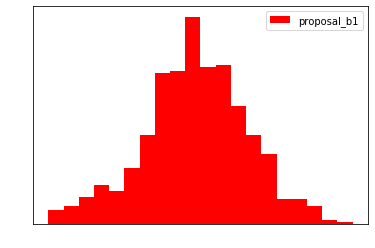

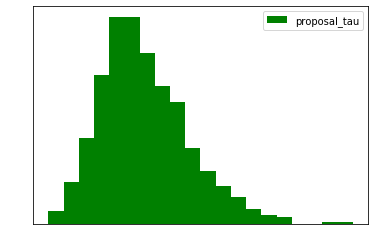

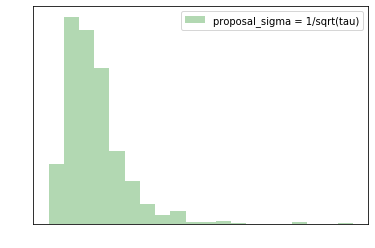

In [49]:
gibbs_sampler.summarize()
gibbs_sampler.compute_DIC()
gibbs_sampler.trace_df.head()
gibbs_sampler.plot_posterior_predictive_dist()
gibbs_sampler.plot_sse()
gibbs_sampler.plot_likelihood()
gibbs_sampler.plot_posterior()

# Diagnostic plots (TODO)

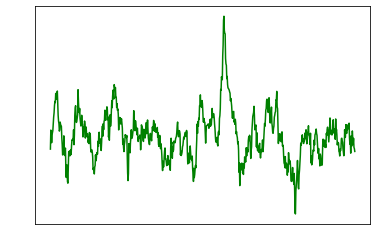

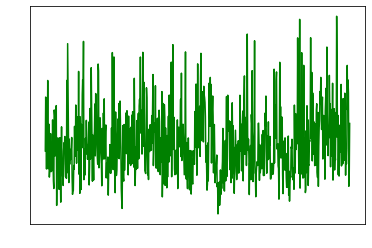

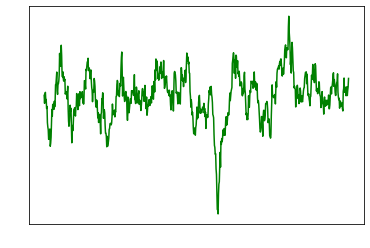

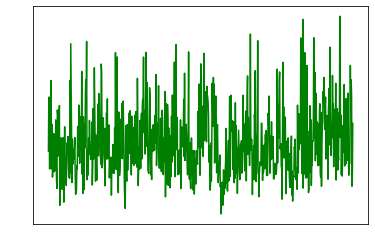

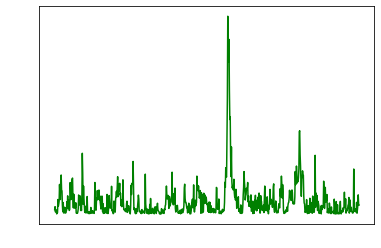

In [12]:
plt.plot(gibbs_sampler.trace_df["mu0"], color="g")
plt.show()
plt.plot(gibbs_sampler.trace_df["tau0"], color="g")
plt.show()
plt.plot(gibbs_sampler.trace_df["mu1"], color="g")
plt.show()
plt.plot(gibbs_sampler.trace_df["tau1"], color="g")
plt.show()
plt.plot(gibbs_sampler.trace_df["beta"], color="g")
plt.show()